### RoBERTa for Sentiment Analysis

* Use Hugging Face's RoBERTa to analyze sentiment in apartment reviews across various subreddits

In [1]:
import sys
sys.path.append("/Users/gabyagrocostea/dev/RentWatchAI/src/")

In [2]:
from ast import literal_eval
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy.special import softmax
import seaborn as sns

In [4]:
sys.path

['/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python313.zip',
 '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13',
 '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload',
 '',
 '/Users/gabyagrocostea/dev/.venv/lib/python3.13/site-packages',
 '/Users/gabyagrocostea/dev/RentWatchAI/src/']

In [10]:
from sentiment_functions import interpret_sentiment, predict_sentiment

In [11]:
sns.set_style('whitegrid')

In [ ]:
!pip install transformers

In [ ]:
# import torch
# import torch.nn.functional as F

In [12]:
# import statements
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer


In [13]:
def preprocess_text(text):
    '''Preprocess text: lowercase, remove newlines, strip'''
    return text.lower().replace('\n', ' ').strip()

In [14]:
data_path = '/Users/gabyagrocostea/dev/RentWatchAI/data/reddit_posts_nyc_apt.csv'

In [15]:
data = pd.read_csv(data_path, index_col=0)

In [ ]:
# read Reddit posts and comments
# data = pd.read_csv('./data/reddit_posts_nyc_apt.csv', index_col=0)

In [16]:
data.head()

,subreddit,title,score,num_comments,url,comments
0,r/NYCapartments,Midtown manhattan Studio with great view,1622,289,https://redd.it/1ditjh8,"['$5000 for a studio 😕', 'It comes with person..."
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1434,57,https://redd.it/1at9s69,"['When can I move in?', 'Wow! What a steal!', ..."
2,r/NYCapartments,Those with high rise skyline apartments do you...,1338,249,https://redd.it/1fwnevs,['I didn’t live in one but I worked at an offi...
3,r/NYCapartments,The rent crisis in NYC is becoming increasingl...,1256,371,https://redd.it/1aq7si7,"['Two incomes no kids.', 'Tell me about it, I ..."
4,r/NYCapartments,Happy Monday everyone,944,199,https://redd.it/1auv5ws,['I think average salary context is needed. Ta...


In [17]:
data.shape

(200, 6)

In [18]:
# turn comments to list
data.comments = data.comments.apply(literal_eval)
# Apply preprocessing
data['cleaned_text'] = data['comments'].apply(lambda x: " ".join(preprocess_text(comment) for comment in x if comment))

In [19]:
# How many comments do we have on posts?
data.comments.map(lambda x: len(x)).sum()

np.int64(9825)

In [20]:
data.cleaned_text[:10]

0    $5000 for a studio 😕 it comes with personal tr...
1    when can i move in? wow! what a steal! pets? 3...
2    i didn’t live in one but i worked at an office...
3    two incomes no kids. tell me about it, i liter...
4    i think average salary context is needed. take...
5    that's tough if you need a work desk in there ...
6    literally all 1 bedrooms for less than 3k is a...
7    guest fee is wild the guest fee doesn't sound ...
8    everyone is different so make the best choice ...
9    yeah, it fucking sucks and just keeps getting ...
Name: cleaned_text, dtype: object

In [22]:
# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


In [23]:
start_time = time.time()
# Predict sentiment based on cleaned_text column
# this return sentiment output with logit values
data['sentiment_output'] = data['cleaned_text'].apply(lambda text: predict_sentiment(text, model, tokenizer))
end_time = time.time()
print(f'Took {end_time-start_time} ms to predict sentiments')
print(f'Took {(end_time-start_time)/60.0} mins to predict sentiments')

Took 43.95729994773865 ms to predict sentiments
Took 0.7326216657956441 mins to predict sentiments


In [24]:
# look at one output
data.sentiment_output.iloc[0]

SequenceClassifierOutput(loss=None, logits=tensor([[-0.7412,  0.1882,  0.6755]]), hidden_states=None, attentions=None)

### Interpret Sentiment Output

In [25]:
# get sentiment prediction and probability from output
data['sentiment_dict'] = data['sentiment_output'].apply(interpret_sentiment)

In [26]:
# extract sentiment and probabilities into 2 separate columns
data['sentiment'] = data.sentiment_dict.map(lambda x: x['label'])
data['sentiment_prob'] = data.sentiment_dict.map(lambda x: x['prob'])

In [27]:
data.head(2)

,subreddit,title,score,num_comments,url,comments,cleaned_text,sentiment_output,sentiment_dict,sentiment,sentiment_prob
0,r/NYCapartments,Midtown manhattan Studio with great view,1622,289,https://redd.it/1ditjh8,"[$5000 for a studio 😕, It comes with personal ...",$5000 for a studio 😕 it comes with personal tr...,"{'logits': [[tensor(-0.7412), tensor(0.1882), ...","{'label': 'positive', 'prob': 0.5385750532150269}",positive,0.538575
1,r/NYCapartments,"Spacious studio on the UWS, great location ste...",1434,57,https://redd.it/1at9s69,"[When can I move in?, Wow! What a steal!, Pets...",when can i move in? wow! what a steal! pets? 3...,"{'logits': [[tensor(0.6609), tensor(0.3187), t...","{'label': 'negative', 'prob': 0.5297321677207947}",negative,0.529732


In [ ]:
# write to csv
data.to_csv('reddit_posts_nyc_apt_sentiment_roberta.csv')

In [28]:
# sample some comments and print their sentiment and probabilities
for ix, row in data[['cleaned_text','sentiment','sentiment_prob']].sample(3).iterrows():
  print(f"{row['cleaned_text'][:200]}")
  print(f"Sentiment: {row['sentiment']}")
  print(f"Probability: {row['sentiment_prob']}\n")

the person hiring the broker (ie the landlord) pay the fee directly.  if that can't happen, then at least make the broker have a legal fiduciary obligation to whomever is directly paying their fee (eg
Sentiment: negative
Probability: 0.5924153327941895

not me but i hope you find someone. co-living is the future. i think this could be great, with the right person, of course. try fb or nyc based mother's groups. also how do you manage to split a studi
Sentiment: positive
Probability: 0.8790856599807739

literally all 1 bedrooms for less than 3k is a “steal” nowadays absolutely! i had to give up my studio apt on e 10th st after 10 years bc my rent went from $2850 to $3700! looks nice ! big ups if that
Sentiment: positive
Probability: 0.39335235953330994



### Notes

* Model Raw Scores - logits
* Softmax converts logits into a probability distribution that represents the models
confidence in each possible class. 
* This allows for easier interpretation and decision-making based on the predicted probabilities.

Example: <br>
* The original logits [-1, 0, 2] represent the model's raw scores for each sentiment class.
* After applying softmax, we get the probabilities [0.045, 0.119, 0.835].
* These probabilities can be interpreted as follows:
  * There's a 4.5% probability the text is negative.
  * There's an 11.9% probability the text is neutral.
  * There's an 83.5% probability the text is positive.


In [29]:
# we notice that sentiment probability averages tend toward what we expect
# high sentiment probability for positive and negative (vs neutral)
data.groupby('sentiment').sentiment_prob.describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,82.0,0.686536,0.138038,0.435413,0.579770,0.701063,0.791551,0.946154
neutral,46.0,0.494294,0.053438,0.386881,0.465983,0.500891,0.527618,0.641039
positive,72.0,0.739631,0.174016,0.393352,0.589239,0.753419,0.904534,0.987342


## Data Visualization

* Sentiment distribution - a big majority of comments are negative
* Sentiment probability distributions: positive and negative are wider ranging and neutral is smallest



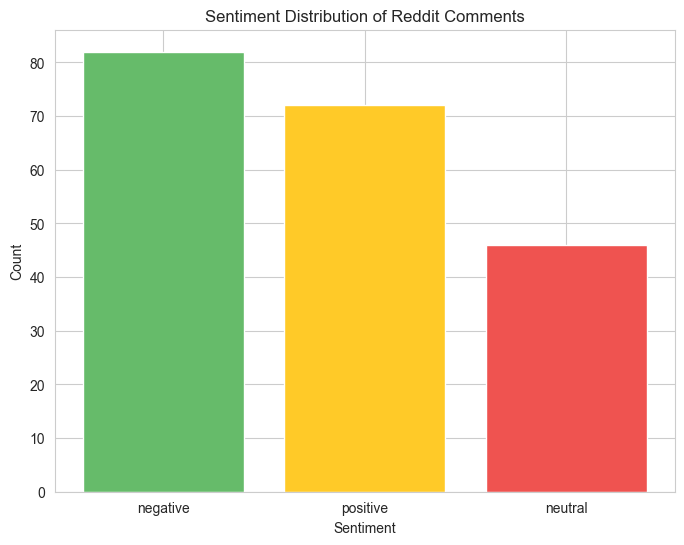

In [30]:
# sentiment values
sentiment_df = data.sentiment.value_counts().reset_index()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_df['sentiment'], sentiment_df['count'], color=['#66BB6A', '#FFCA28', '#EF5350'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Reddit Comments')
plt.show()


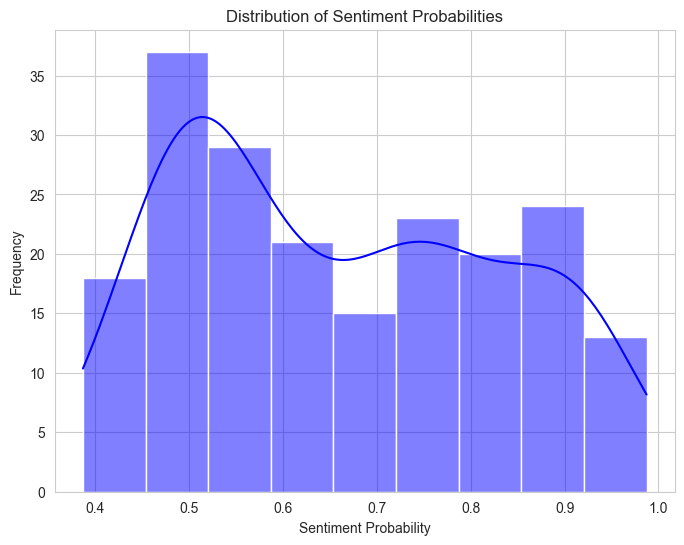

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data.sentiment_prob, ax=ax, kde=True, color='Blue')
_ = ax.set_title('Distribution of Sentiment Probabilities')
_ = ax.set_xlabel('Sentiment Probability')
_ = ax.set_ylabel('Frequency')

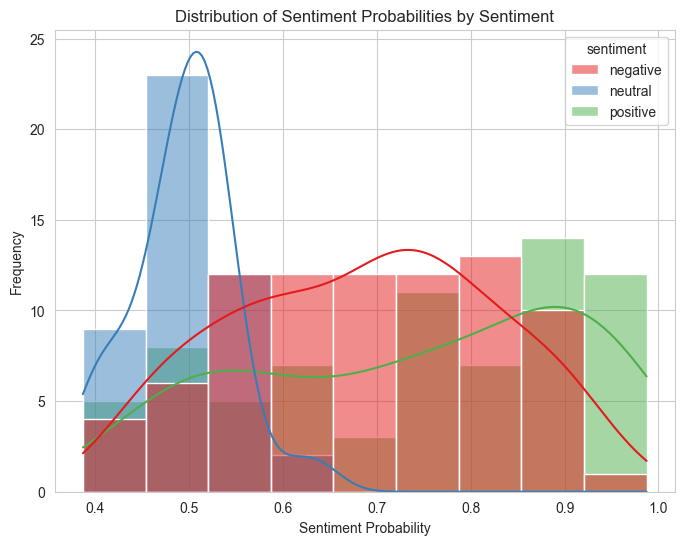

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data, x='sentiment_prob', hue='sentiment', ax=ax, kde=True,
             hue_order=['negative', 'neutral', 'positive'],
             palette='Set1')
_ = ax.set_title('Distribution of Sentiment Probabilities by Sentiment')
_ = ax.set_xlabel('Sentiment Probability')
_ = ax.set_ylabel('Frequency')

In [33]:
sentiment_counts = data.sentiment.value_counts().reset_index()
sentiment_counts

,sentiment,count
0,negative,82
1,positive,72
2,neutral,46


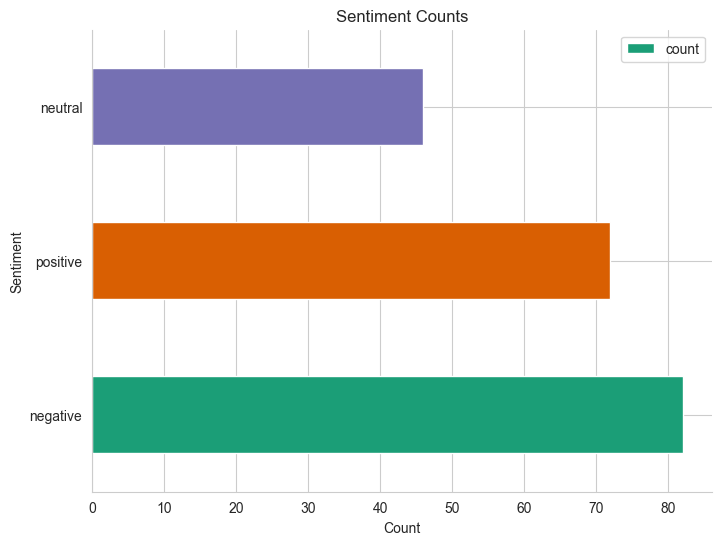

In [34]:
# plot sentiment counts
fig, ax = plt.subplots(figsize=(8, 6))
g = sentiment_counts.plot(kind='barh', x = 'sentiment', y ='count',
                      color=sns.palettes.mpl_palette('Dark2'), ax=ax)
_ = plt.xlabel('Count')
_ =  plt.ylabel('Sentiment')
_ =  plt.title('Sentiment Counts')
_ =  plt.gca().spines[['top', 'right',]].set_visible(False)

/var/folders/y4/8c0n8_2x5fq9rd9gn92lqkvm0000gn/T/ipykernel_25328/3586292231.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='sentiment_prob', y='sentiment', inner='stick', palette='Set1')


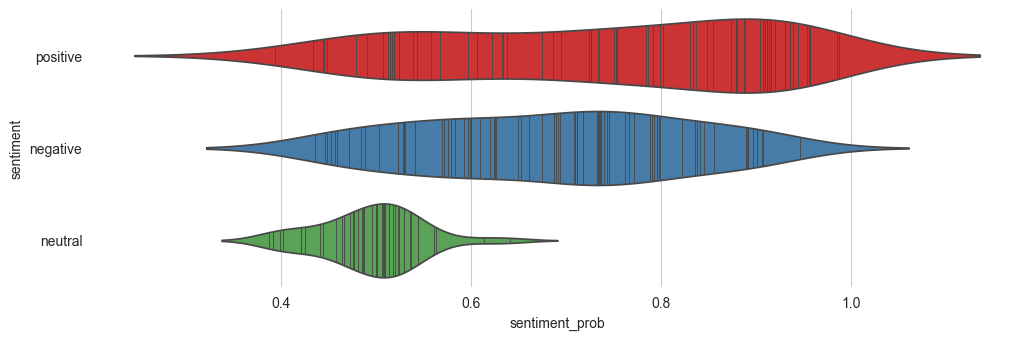

In [35]:
# sentiment vs sentiment_prob

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(data['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='sentiment_prob', y='sentiment', inner='stick', palette='Set1')
sns.despine(top=True, right=True, bottom=True, left=True)